In [1]:
import xarray as xr
xr.set_options(display_style='html')
import intake
import cftime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd
import dask
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import cartopy as cy
#from functions import trend
import os as os
#import pymannkendall as mk
%matplotlib inline

In [2]:
! pip install pymannkendall
import pymannkendall as mk

  Using cached pymannkendall-1.4.2-py3-none-any.whl (12 kB)


#### what to do:
- look at seasonalities
- look at aerosol distrubutions

In [3]:
def trend(ds, variable, var=True):#, season):
    
    if var:
        array_var = ds[variable].values
    else:
        array_var = ds.values
        
    # create a dataset with same lon and lat as the precipitation dataset
    ds_trend = xr.Dataset({'lat': ds.lat,'lon': ds.lon})
    # add ds_trend_DJF to ds_NorESM2_MM_precip_season_trend
    # ds_season = ds.groupby('time.season').mean(keep_attrs=True) eks
    ds_trend['mk_trend'] = (['lat', 'lon'], np.zeros((ds.lat.shape[0], ds.lon.shape[0]))*np.nan)
    ds_trend['mk_intercept'] = (['lat', 'lon'], np.zeros((ds.lat.shape[0], ds.lon.shape[0]))*np.nan)
    ds_trend['mk_p_val'] = (['lat', 'lon'], np.zeros((ds.lat.shape[0], ds.lon.shape[0]))*np.nan)  
    #array_var = ds[variable].values
    for ilat in range(array_var.shape[1]):
        for ilon in range(array_var.shape[2]):
            ts = array_var[:, ilat, ilon]
            results = mk.original_test(ts)
            ds_trend['mk_trend'][ilat, ilon] = results[7]
            ds_trend['mk_intercept'][ilat, ilon] = results[8]
            ds_trend['mk_p_val'][ilat, ilon] = results[2]
    return ds_trend
      


In [4]:
def dot_signif(ds, ax):
    for ilat, lat in enumerate(ds.lat):
        for ilon, lon in enumerate(ds.lon):
            if ds.mk_p_val.isel(lat=ilat, lon=ilon) < 0.05:
                if (ilon % 3 == 0) and (ilat % 3 == 0):
                    ax.plot(lon, lat, marker='o', color='k', transform=ccrs.PlateCarree(), markersize=1)

In [5]:
def plot_map(ds_var, title, reverse=False, levels=6, extent=[-180,180,90,50], vmin=-0.12, vmax=0.12):
    '''
        Plots the trend on a map from the model data
        
    Args:
    -----
        var    [DataArray]   :   An xarray contining data about the conditions 
        levels [int]         :   Levels in the plot
        extent [list]        :   A list of the extent of the plot
    '''
    if reverse:
            cmap="RdBu_r"
    else:
            cmap='RdBu'
    
    sat_proj = ccrs.NorthPolarStereo()
    fig, ax = plt.subplots(figsize=(7,7),subplot_kw={'projection':sat_proj})
    ds_var.plot(facecolor="gray",
        ax = ax,
        cbar_kwargs={
            'orientation':'vertical',
            'shrink':.8
            },                 
        transform=ccrs.PlateCarree(),
        #levels=levels,
        vmin=vmin,
        vmax=vmax,
        cmap=cmap
        #robust=True
        )


    #dot_signif(ds, ax)
    
    #cbar.set_clim(min, max)
    ax.set_extent(extent, ccrs.PlateCarree())
    ax.gridlines(draw_labels=True)
    ax.coastlines()
    ax.set_title(title, fontweight='bold', fontsize=15)
    fig.tight_layout()

In [75]:


def plot_map2(ds_var1, ds_var2, title, reverse=False, levels=6, extent=[-180,180,90,50], vmin=-0.12, vmax=0.12):
    '''
        Plots the trend on a map from the model data
        
    Args:
    -----
        var    [DataArray]   :   An xarray contining data about the conditions 
        levels [int]         :   Levels in the plot
        extent [list]        :   A list of the extent of the plot
    '''
    if reverse:
            cmap="RdBu_r"
    else:
            cmap='RdBu'
    
    sat_proj = ccrs.NorthPolarStereo()
    fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(8,8),subplot_kw={'projection':sat_proj})
    ax=ax.flatten()
    ds_var1.plot(facecolor="gray",
        ax = ax[0],
        cbar_kwargs={
            'orientation':'vertical',
            'shrink':.8
            },                 
        transform=ccrs.PlateCarree(),
        #levels=levels,
        vmin=-10,
        vmax=10,
        cmap=cmap
        #robust=True
        )
    
    ds_var2.plot(facecolor="gray",
        ax = ax[1],
        cbar_kwargs={
            'orientation':'vertical',
            'shrink':.7
            },                 
        transform=ccrs.PlateCarree(),
        #levels=levels,
        vmin=vmin,
        vmax=vmax,
        cmap=cmap
        #robust=True
        )


    #dot_signif(ds, ax)
    
    #cbar.set_clim(min, max)
    ax[0].set_extent(extent, ccrs.PlateCarree())
    ax[0].gridlines(draw_labels=True)
    ax[0].coastlines()
    ax[0].set_title(title, fontweight='bold', fontsize=15)
    
    
    ax[1].set_extent(extent, ccrs.PlateCarree())
    ax[1].gridlines(draw_labels=True)
    ax[1].coastlines()
    ax[1].set_title(title, fontweight='bold', fontsize=15)
    fig.tight_layout()

In [7]:
def fancy(ax, fontsize):
    
    # thickning the axes spines
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)
        ax.spines[axis].set_color('k')
        
    # set the fontsize for all your ticks
    #fontsize = 15
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
        
    # properties of the ticks
    ax.tick_params(direction='out', length=8, width=2, pad=10, bottom=True, top=False, left=True, right=False, color='k')
    
    # add a grid to the plot
    ax.grid(True, alpha=0.5)
    
    # mask top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

#### Reading files from piControl for the first 30 years

In [8]:
# Read in multiple piControl files:

list_of_files10_piControl = [
    '../../Data/ccn_AERmon_NorESM2-MM_piControl_r1i1p1f1_gn_120001-120912.nc',
    '../../Data/cdnc_AERmon_NorESM2-MM_piControl_r1i1p1f1_gn_120001-120912.nc',
    '../../Data/co2_AERmon_NorESM2-MM_piControl_r1i1p1f1_gn_120001-120912.nc',
    #'../../Data/dms_AERmon_NorESM2-MM_piControl_r1i1p1f1_gn_120001-120912.nc',
    '../../Data/emibc_AERmon_NorESM2-MM_piControl_r1i1p1f1_gn_120001-120912.nc',
    '../../Data/emibvoc_AERmon_NorESM2-MM_piControl_r1i1p1f1_gn_120001-120912.nc',
    #'../../Data/emidms_AERmon_NorESM2-MM_piControl_r1i1p1f1_gn_120001-120912.nc',
    '../../Data/emidust_AERmon_NorESM2-MM_piControl_r1i1p1f1_gn_120001-120912.nc',
    '../../Data/emioa_AERmon_NorESM2-MM_piControl_r1i1p1f1_gn_120001-120912.nc',
    '../../Data/emiso2_AERmon_NorESM2-MM_piControl_r1i1p1f1_gn_120001-120912.nc',
    '../../Data/emiso4_AERmon_NorESM2-MM_piControl_r1i1p1f1_gn_120001-120912.nc',
    '../../Data/emiss_AERmon_NorESM2-MM_piControl_r1i1p1f1_gn_120001-120912.nc',
    '../../Data/pr_Amon_NorESM2-MM_piControl_r1i1p1f1_gn_120001-120912.nc',
    '../../Data/prc_Amon_NorESM2-MM_piControl_r1i1p1f1_gn_120001-120912.nc',
    '../../Data/ts_Amon_NorESM2-MM_piControl_r1i1p1f1_gn_120001-120912.nc',
    '../../Data/so2_AERmon_NorESM2-MM_piControl_r1i1p1f1_gn_120001-120912.nc',
    '../../Data/emivoc_AERmon_NorESM2-MM_piControl_r1i1p1f1_gn_120001-120912.nc',
    '../../Data/emiisop_AERmon_NorESM2-MM_piControl_r1i1p1f1_gn_120001-120912.nc'
]

ds_piControl10 = xr.open_mfdataset(list_of_files10_piControl, combine='by_coords', compat='override', use_cftime=True)#concat_dim='time',combine='by_coords')



In [9]:
ds_piControl10 = ds_piControl10.assign_coords(lon=(((ds_piControl10.lon + 180) % 360) - 180)).sortby('lon')
ds_piControl10

/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/srv/conda/envs/note

<xarray.Dataset>
Dimensions:    (time: 120, bnds: 2, lev: 32, lat: 192, lon: 288)
Coordinates:
  * time       (time) object 1200-01-16 12:00:00 ... 1209-12-16 12:00:00
  * lev        (lev) float64 0.9926 0.9763 0.9575 ... 0.01436 0.007595 0.003643
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 -180.0 -178.8 -177.5 -176.2 ... 176.2 177.5 178.8
Dimensions without coordinates: bnds
Data variables: (12/26)
    time_bnds  (time, bnds) object dask.array<chunksize=(120, 2), meta=np.ndarray>
    lev_bnds   (lev, bnds) float64 dask.array<chunksize=(32, 2), meta=np.ndarray>
    p0         float64 ...
    a          (lev) float64 dask.array<chunksize=(32,), meta=np.ndarray>
    b          (lev) float64 dask.array<chunksize=(32,), meta=np.ndarray>
    ps         (time, lat, lon) float32 dask.array<chunksize=(120, 192, 288), meta=np.ndarray>
    ...         ...
    emiso4     (time, lat, lon) float32 dask.array<chunksize=(120, 192, 288), meta=np.ndarray>
    emiss      (time, lat, lon) float32 dask.array<chunksize=(120, 192, 288), meta=np.ndarray>
    emivoc     (time, lat, lon) float32 dask.array<chunksize=(120, 192, 288), meta=np.ndarray>
    pr         (time, lat, lon) float32 dask.array<chunksize=(120, 192, 288), meta=np.ndarray>
    prc        (time, lat, lon) float32 dask.array<chunksize=(120, 192, 288), meta=np.ndarray>
    ts         (time, lat, lon) float32 dask.array<chunksize=(120, 192, 288), meta=np.ndarray>
Attributes: (12/49)
    Conventions:               CF-1.7 CMIP-6.2
    activity_id:               CMIP
    branch_method:             Hybrid-restart from year 1200-01-01 of piContr...
    branch_time:               0.0
    branch_time_in_child:      0.0
    branch_time_in_parent:     438000.0
    ...                        ...
    title:                     NorESM2-MM output prepared for CMIP6
    variable_id:               cdnc
    variant_label:             r1i1p1f1
    license:                   CMIP6 model data produced by NCC is licensed u...
    cmor_version:              3.5.0
    tracking_id:               hdl:21.14100/9514c407-05be-44d4-9aee-cdf51d923312

In [10]:

ds_piControl20 = xr.open_mfdataset('../../Data/NorESM2-MM_piControl_r1i1p1f1_gn_121001-121912.nc', use_cftime=True)#concat_dim='time',combine='by_coords')
ds_piControl30 = xr.open_mfdataset('../../Data/NorESM2-MM_piControl_r1i1p1f1_gn_122001-122912.nc', use_cftime=True)#concat_dim='time',combine='by_coords')


#### Reading files from 4xco2 experiment for the first 30 years

In [11]:

ds_4xco2_10 = xr.open_mfdataset('../../Data/all_NorESM2-MM_abrupt-4xCO2_r1i1p1f1_000101-001012.nc', use_cftime=True)#concat_dim='time',combine='by_coords')



In [12]:
list_of_files20 = [
    '../../Data/ccn_AERmon_NorESM2-MM_abrupt-4xCO2_r1i1p1f1_gn_001101-002012.nc',
    '../../Data/pr_Amon_NorESM2-MM_abrupt-4xCO2_r1i1p1f1_gn_001101-002012.nc',
    '../../Data/cdnc_AERmon_NorESM2-MM_abrupt-4xCO2_r1i1p1f1_gn_001101-002012.nc',
    '../../Data/co2_AERmon_NorESM2-MM_abrupt-4xCO2_r1i1p1f1_gn_001101-002012.nc',
    '../../Data/emibc_AERmon_NorESM2-MM_abrupt-4xCO2_r1i1p1f1_gn_001101-002012.nc',
    '../../Data/emibvoc_AERmon_NorESM2-MM_abrupt-4xCO2_r1i1p1f1_gn_001101-002012.nc',
    '../../Data/emidust_AERmon_NorESM2-MM_abrupt-4xCO2_r1i1p1f1_gn_001101-002012.nc',
    '../../Data/emiisop_AERmon_NorESM2-MM_abrupt-4xCO2_r1i1p1f1_gn_001101-002012.nc',
    '../../Data/emioa_AERmon_NorESM2-MM_abrupt-4xCO2_r1i1p1f1_gn_001101-002012.nc',
    '../../Data/emiso2_AERmon_NorESM2-MM_abrupt-4xCO2_r1i1p1f1_gn_001101-002012.nc',
    '../../Data/emiso4_AERmon_NorESM2-MM_abrupt-4xCO2_r1i1p1f1_gn_001101-002012.nc',
    '../../Data/emiss_AERmon_NorESM2-MM_abrupt-4xCO2_r1i1p1f1_gn_001101-002012.nc',
    '../../Data/emivoc_AERmon_NorESM2-MM_abrupt-4xCO2_r1i1p1f1_gn_001101-002012.nc',
    '../../Data/prc_Amon_NorESM2-MM_abrupt-4xCO2_r1i1p1f1_gn_001101-002012.nc',
    '../../Data/so2_AERmon_NorESM2-MM_abrupt-4xCO2_r1i1p1f1_gn_001101-002012.nc',
    '../../Data/ts_Amon_NorESM2-MM_abrupt-4xCO2_r1i1p1f1_gn_001101-002012.nc']

ds_4xco2_20 = xr.open_mfdataset(list_of_files20, combine='by_coords', compat='override', use_cftime=True)#concat_dim='time',combine='by_coords')

In [13]:
list_of_files30 = [
    #'../../Data/all_NorESM2-MM_abrupt-4xCO2_r1i1p1f1_000101-001012.nc',
    '../../Data/ccn_AERmon_NorESM2-MM_abrupt-4xCO2_r1i1p1f1_gn_002101-003012.nc',
    '../../Data/pr_Amon_NorESM2-MM_abrupt-4xCO2_r1i1p1f1_gn_002101-003012.nc',
    '../../Data/cdnc_AERmon_NorESM2-MM_abrupt-4xCO2_r1i1p1f1_gn_002101-003012.nc',
    '../../Data/co2_AERmon_NorESM2-MM_abrupt-4xCO2_r1i1p1f1_gn_002101-003012.nc',
    '../../Data/emibc_AERmon_NorESM2-MM_abrupt-4xCO2_r1i1p1f1_gn_002101-003012.nc',
    '../../Data/emibvoc_AERmon_NorESM2-MM_abrupt-4xCO2_r1i1p1f1_gn_002101-003012.nc',
    #'../../Tjaernoe2022-group7/ingrblu/emidms_AERmon_NorESM2-LM_abrupt-4xCO2_r1i1p1f1_gn_001101-002012.nc',
    '../../Data/emidust_AERmon_NorESM2-MM_abrupt-4xCO2_r1i1p1f1_gn_002101-003012.nc',
    '../../Data/emiisop_AERmon_NorESM2-MM_abrupt-4xCO2_r1i1p1f1_gn_002101-003012.nc',
    '../../Data/emioa_AERmon_NorESM2-MM_abrupt-4xCO2_r1i1p1f1_gn_002101-003012.nc',
    '../../Data/emiso2_AERmon_NorESM2-MM_abrupt-4xCO2_r1i1p1f1_gn_002101-003012.nc',
    '../../Data/emiso4_AERmon_NorESM2-MM_abrupt-4xCO2_r1i1p1f1_gn_002101-003012.nc',
    '../../Data/emiss_AERmon_NorESM2-MM_abrupt-4xCO2_r1i1p1f1_gn_002101-003012.nc',
    '../../Data/emivoc_AERmon_NorESM2-MM_abrupt-4xCO2_r1i1p1f1_gn_002101-003012.nc',
    '../../Data/prc_Amon_NorESM2-MM_abrupt-4xCO2_r1i1p1f1_gn_002101-003012.nc',
    '../../Data/so2_AERmon_NorESM2-MM_abrupt-4xCO2_r1i1p1f1_gn_002101-003012.nc',
    '../../Data/ts_Amon_NorESM2-MM_abrupt-4xCO2_r1i1p1f1_gn_002101-003012.nc']

ds_4xco2_30 = xr.open_mfdataset(list_of_files30, combine='by_coords', compat='override', use_cftime=True)#concat_dim='time',combine='by_coords')


#### Making the datasets from each experiment fit each other before concatenating 

#### 4xco2

In [14]:
time20 = ds_4xco2_20.time.values
time30 = ds_4xco2_30.time.values


In [15]:
def convert(ds, list_of_files, time):

    levels = ds_4xco2_10.lev.values
    lat = ds_4xco2_10.lat.values
    lon = ds_4xco2_10.lon.values

        

    ds_all = xr.Dataset({'time': time, 'lev': levels, 'lat': lat,'lon': lon})
    for path in list_of_files:
            ds = xr.open_dataset(path)
            for var in ds.data_vars:
                    a = str(var)
            try:
                    ds_all[a] = (['time', 'lat', 'lon'], ds[a].values)
            except:
                    print(path)
                    ds_all[a] = (['time', 'lev', 'lat', 'lon'], ds[a].values)

    ds_all = ds_all.assign_coords(lon=(((ds.lon + 180) % 360) - 180)).sortby('lon')
    return ds_all


In [16]:
ds_20 = convert(ds_4xco2_20, list_of_files20, time20)

../../Data/cdnc_AERmon_NorESM2-MM_abrupt-4xCO2_r1i1p1f1_gn_001101-002012.nc
../../Data/co2_AERmon_NorESM2-MM_abrupt-4xCO2_r1i1p1f1_gn_001101-002012.nc
../../Data/so2_AERmon_NorESM2-MM_abrupt-4xCO2_r1i1p1f1_gn_001101-002012.nc


In [17]:
ds_30 = convert(ds_4xco2_30, list_of_files30, time30)

../../Data/cdnc_AERmon_NorESM2-MM_abrupt-4xCO2_r1i1p1f1_gn_002101-003012.nc
../../Data/co2_AERmon_NorESM2-MM_abrupt-4xCO2_r1i1p1f1_gn_002101-003012.nc
../../Data/so2_AERmon_NorESM2-MM_abrupt-4xCO2_r1i1p1f1_gn_002101-003012.nc


#### piControl

In [18]:
variables = ["time_bnds", "lev_bnds", "p0", "a", "b", "ps", "a_bnds", "b_bnds", "lat_bnds", "lon_bnds"]
ds_piControl10 = ds_piControl10.drop_vars(variables)

variables = ["dms", "emidms"]
ds_piControl20 = ds_piControl20.drop_vars(variables)
ds_piControl30 = ds_piControl30.drop_vars(variables)

#### Making the datasets into one for each experiment

In [19]:
var_list = ['pr', 'ccn', 'cdnc', 'co2', 'emibc', 'emibvoc', 'emidust', 'emiisop', 'emioa', 'emiso2', 'emiso4', 'emiss', 'emivoc', 'prc', 'so2', 'ts']


ds_all = xr.concat([ds_4xco2_10[var_list], ds_20[var_list], ds_30[var_list]], dim="time")

In [20]:
ds_all_piControl = xr.concat([ds_piControl10[var_list], ds_piControl20[var_list], ds_piControl30[var_list]], dim='time')



In [21]:
def annual(ds):
    return ds.resample(time="Y").mean()


ds_4xco2_NorESM_y = annual(ds_all)
ds_piControl_NorESM_y = annual(ds_all_piControl)

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/array/routines.py:1995: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return a[(slice(None),) * axis + (indices,)]


In [22]:
def fix_units(ds):
    ds['pr'] = ds['pr']*86400 # mm/year
    ds['pr'] = ds['pr'].assign_attrs(units='mm/year')
    ds['ts'] = ds['ts']-273.15 # C
    ds['ts'] = ds['ts'].assign_attrs(units='C$^\circ$')
    ds['ccn'] = ds['ccn']/100 # cm-3
    ds['ccn'] = ds['ccn'].assign_attrs(units='cm$^{-3}$')
    return ds

In [23]:
ds_4xco2_NorESM_y = fix_units(ds_4xco2_NorESM_y)
ds_piControl_NorESM_y = fix_units(ds_piControl_NorESM_y)

### Time series plots - Global and Arctic mean

In [24]:
def weighted_mean(ds):
    weights = np.cos(np.deg2rad(ds.lat))
    weights.name = "weights"
    air_weighted = ds.weighted(weights)
    weighted_mean = air_weighted.mean(("lon", "lat"))
    return weighted_mean


In [54]:
# Arctic 

max_lat = 90
min_lat = 70
max_lon = 135
min_lon = 45

mask_lon = (ds_4xco2_NorESM_y.lon >= min_lon) & (ds_4xco2_NorESM_y.lon <= max_lon)
mask_lat = (ds_4xco2_NorESM_y.lat >= min_lat) & (ds_4xco2_NorESM_y.lat<= max_lat)

ds_arctic_4xco2 = ds_4xco2_NorESM_y.where(mask_lon & mask_lat, drop=True)



In [26]:

mask_lon_pi = (ds_piControl_NorESM_y.lon >= min_lon) & (ds_piControl_NorESM_y.lon <= max_lon)
mask_lat_pi = (ds_piControl_NorESM_y.lat >= min_lat) & (ds_piControl_NorESM_y.lat<= max_lat)


ds_arctic_piControl = ds_piControl_NorESM_y.where(mask_lon & mask_lat, drop=True)

In [27]:
arctic_mean_4xco2 = weighted_mean(ds_arctic_4xco2)
global_mean_4xco2 = weighted_mean(ds_4xco2_NorESM_y)


arctic_mean_piControl = weighted_mean(ds_arctic_piControl)
global_mean_piControl = weighted_mean(ds_piControl_NorESM_y)

In [55]:
#Result part

timepoints = []

for i in range(len(global_mean_4xco2['time'])):
    timepoints.append(i)


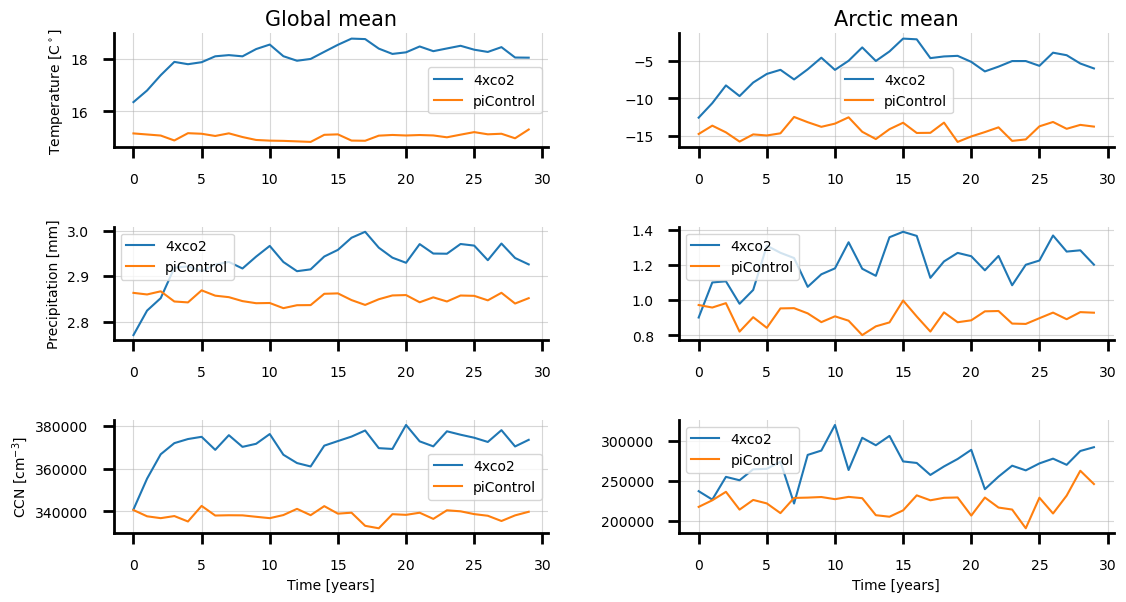

In [67]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(10, 5))

gs = gridspec.GridSpec(ncols=2, nrows=3, hspace = 0.7, wspace = 0.3, top = 1,
                       bottom = 0, left = 0, right = 1)

# create an ax with gs
ax = fig.add_subplot(gs[0, 0])
ax.plot(timepoints, global_mean_4xco2['ts'], label='4xco2')
ax.plot(timepoints, global_mean_piControl['ts'], label='piControl')
#ax.plot(timepoints, global_mean_4xco2['ts'].values-global_mean_piControl['ts'].values)#, label='4xco2')
ax.set_title('Global mean', size=15)
ax.set_ylabel('Temperature [C$^\circ$]')
ax.legend()
fancy(ax, 10)
#fig.suptitle('h')
#hide_ticks(ax)
#ax.text(0, 0, 'gs[0:4, 0:2]', fontsize=17, color='red', transform=ax.transAxes, 
        #horizontalalignment='center', verticalalignment='center')

ax = fig.add_subplot(gs[1, 0])
#hide_ticks(ax)
ax.plot(timepoints, global_mean_4xco2['pr'], label='4xco2')
ax.plot(timepoints, global_mean_piControl['pr'], label='piControl')
#ax.set_title('Precipitation')
ax.set_ylabel('Precipitation [mm]')
ax.legend()
fancy(ax, 10)

ax = fig.add_subplot(gs[2, 0])
#hide_ticks(ax)
ax.plot(timepoints, global_mean_4xco2['ccn'], label='4xco2')
ax.plot(timepoints, global_mean_piControl['ccn'], label='piControl')
#ax.set_title('CCN')
ax.set_xlabel('Time [years]')
ax.set_ylabel('CCN [cm$^{-3}$]')
ax.legend()
fancy(ax, 10)

ax = fig.add_subplot(gs[0, 1])
#hide_ticks(ax)
ax.plot(timepoints, arctic_mean_4xco2['ts'], label='4xco2')
ax.plot(timepoints, arctic_mean_piControl['ts'], label='piControl')
ax.set_title('Arctic mean', size=15)
ax.legend()
fancy(ax, 10)

ax = fig.add_subplot(gs[1, 1])
#hide_ticks(ax)
ax.plot(timepoints, arctic_mean_4xco2['pr'], label='4xco2')
ax.plot(timepoints, arctic_mean_piControl['pr'], label='piControl')
#ax.set_title('Precipitation')
ax.legend()
fancy(ax, 10)

ax = fig.add_subplot(gs[2, 1])
#hide_ticks(ax)
ax.plot(timepoints, arctic_mean_4xco2['ccn'], label='4xco2')
ax.plot(timepoints, arctic_mean_piControl['ccn'], label='piControl')
#ax.set_title('CCN')
ax.set_xlabel('Time [years]')
#ax.set_yscale('log')
ax.legend()
fancy(ax, 10)

In [68]:
diff_ts = global_mean_4xco2['ts'].values-global_mean_piControl['ts'].values

In [69]:
percentile75 = diff_ts.quantile(0.75)
percentile25 = diff_ts.quantile(0.25)

AttributeError: 'numpy.ndarray' object has no attribute 'quantile'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


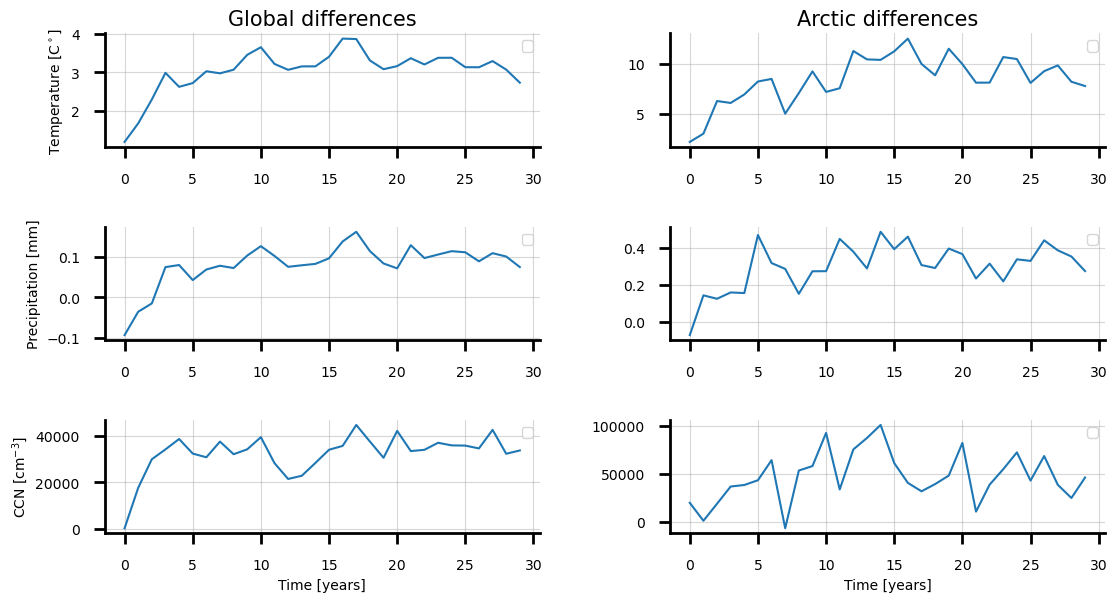

In [30]:

fig = plt.figure(figsize=(10, 5))

gs = gridspec.GridSpec(ncols=2, nrows=3, hspace = 0.7, wspace = 0.3, top = 1,
                       bottom = 0, left = 0, right = 1)

# create an ax with gs
ax = fig.add_subplot(gs[0, 0])
ax.plot(timepoints, global_mean_4xco2['ts'].values-global_mean_piControl['ts'].values)#, label='4xco2')
#ax.plot(timepoints, global_mean_piControl['ts'], label='piControl')
ax.set_title('Global differences', size=15)
ax.set_ylabel('Temperature [C$^\circ$]')
ax.legend()
fancy(ax, 10)
#fig.suptitle('h')
#hide_ticks(ax)
#ax.text(0, 0, 'gs[0:4, 0:2]', fontsize=17, color='red', transform=ax.transAxes, 
        #horizontalalignment='center', verticalalignment='center')

ax = fig.add_subplot(gs[1, 0])
#hide_ticks(ax)
ax.plot(timepoints, global_mean_4xco2['pr'].values-global_mean_piControl['pr'].values)#, label='4xco2')
#ax.plot(timepoints, global_mean_piControl['pr'], label='piControl')
#ax.set_title('Precipitation')
ax.set_ylabel('Precipitation [mm]')
ax.legend()
fancy(ax, 10)

ax = fig.add_subplot(gs[2, 0])
#hide_ticks(ax)
ax.plot(timepoints, global_mean_4xco2['ccn'].values-global_mean_piControl['ccn'].values)#, label='4xco2')
#ax.plot(timepoints, global_mean_piControl['ccn'], label='piControl')
#ax.set_title('CCN')
ax.set_xlabel('Time [years]')
ax.set_ylabel('CCN [cm$^{-3}$]')
ax.legend()
fancy(ax, 10)

ax = fig.add_subplot(gs[0, 1])
#hide_ticks(ax)
ax.plot(timepoints, arctic_mean_4xco2['ts'].values- arctic_mean_piControl['ts'].values)#, label='4xco2')
#ax.plot(timepoints, arctic_mean_piControl['ts'], label='piControl')
ax.set_title('Arctic differences', size=15)
ax.legend()
fancy(ax, 10)

ax = fig.add_subplot(gs[1, 1])
#hide_ticks(ax)
ax.plot(timepoints, arctic_mean_4xco2['pr'].values-arctic_mean_piControl['pr'].values)#, label='4xco2')
#ax.plot(timepoints, arctic_mean_piControl['pr'], label='piControl')
#ax.set_title('Precipitation')
ax.legend()
fancy(ax, 10)

ax = fig.add_subplot(gs[2, 1])
#hide_ticks(ax)
ax.plot(timepoints, arctic_mean_4xco2['ccn'].values-arctic_mean_piControl['ccn'].values)#, label='4xco2')
#ax.plot(timepoints, arctic_mean_piControl['ccn'], label='piControl')
#ax.set_title('CCN')
ax.set_xlabel('Time [years]')
#ax.set_yscale('log')
ax.legend()
fancy(ax, 10)

### Plotting the difference after 5 first years


In [31]:
ts_4xco2_stabel = ds_4xco2_NorESM_y['ts'][5:]; ts_piControl_stabel = ds_piControl_NorESM_y['ts'][5:]

pr_4xco2_stabel = ds_4xco2_NorESM_y['pr'][5:]; pr_piControl_stabel = ds_piControl_NorESM_y['pr'][5:]

ccn_4xco2_stabel = ds_4xco2_NorESM_y['ccn'][5:]; ccn_piControl_stabel = ds_piControl_NorESM_y['ccn'][5:]


In [32]:
ts_4xco2_stabel.mean().values

array(8.856214, dtype=float32)

In [52]:
#Bruk denne!!!!

ds_4xco2_NorESM_y.mean('time', keep_attrs=True)

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288, lev: 32)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 -180.0 -178.8 -177.5 -176.2 ... 176.2 177.5 178.8
  * lev      (lev) float64 0.9926 0.9763 0.9575 ... 0.01436 0.007595 0.003643
Data variables: (12/16)
    pr       (lat, lon) float64 dask.array<chunksize=(192, 288), meta=np.ndarray>
    ccn      (lat, lon) float32 dask.array<chunksize=(192, 288), meta=np.ndarray>
    cdnc     (lev, lat, lon) float32 dask.array<chunksize=(32, 96, 96), meta=np.ndarray>
    co2      (lev, lat, lon) float32 dask.array<chunksize=(32, 96, 96), meta=np.ndarray>
    emibc    (lat, lon) float32 dask.array<chunksize=(192, 288), meta=np.ndarray>
    emibvoc  (lat, lon) float32 dask.array<chunksize=(192, 288), meta=np.ndarray>
    ...       ...
    emiso4   (lat, lon) float32 dask.array<chunksize=(192, 288), meta=np.ndarray>
    emiss    (lat, lon) float32 dask.array<chunksize=(192, 288), meta=np.ndarray>
    emivoc   (lat, lon) float32 dask.array<chunksize=(192, 288), meta=np.ndarray>
    prc      (lat, lon) float32 dask.array<chunksize=(192, 288), meta=np.ndarray>
    so2      (lev, lat, lon) float32 dask.array<chunksize=(32, 96, 96), meta=np.ndarray>
    ts       (lat, lon) float32 dask.array<chunksize=(192, 288), meta=np.ndarray>

In [34]:
ts_4xco2_mean = ts_4xco2_stabel.resample(time="25Y").mean()[:1]
ts_piControl_mean = ts_piControl_stabel.resample(time="25Y").mean()[:1]
temp_diff = ts_4xco2_mean.values-ts_piControl_mean.values

pr_4xco2_mean = pr_4xco2_stabel.resample(time="25Y").mean()[:1]
pr_piControl_mean = pr_piControl_stabel.resample(time="25Y").mean()[:1]
pr_diff = pr_4xco2_mean.values-pr_piControl_mean.values

ccn_4xco2_mean = ccn_4xco2_stabel.resample(time="25Y").mean()[:1]
ccn_piControl_mean = ccn_piControl_stabel.resample(time="25Y").mean()[:1]
ccn_diff = ccn_4xco2_mean.values-ccn_piControl_mean.values

/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)
/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregations.py:258: RuntimeWarning: invalid value encountered in divide
  finalize=lambda sum_, count: sum_ / count,


In [35]:
def create_ds(old_ds, var, values):
    lat = old_ds.lat.values
    lon = old_ds.lon.values
    time = old_ds.time.values

    ds_old = xr.Dataset({'time': time, 'lat': lat,'lon': lon})
    ds_old[var] = (['time', 'lat', 'lon'], values)
    return ds_old


    

In [36]:
ds_temp_diff = create_ds(ts_4xco2_mean, 'ts_diff', temp_diff)
ds_pr_diff = create_ds(pr_4xco2_mean, 'pr_diff', pr_diff)
ds_ccn_diff = create_ds(ccn_4xco2_mean, 'ccn_diff', ccn_diff)

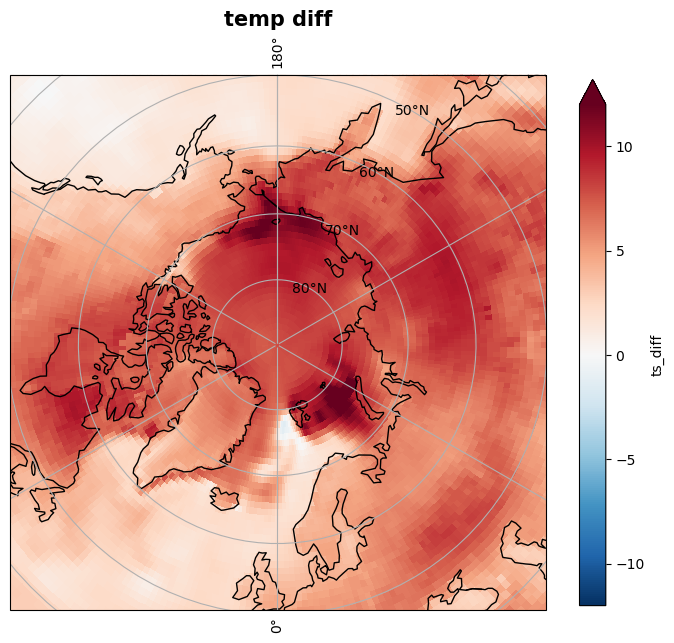

In [37]:
plot_map(ds_temp_diff['ts_diff'], 'temp diff', reverse=True, vmin=-12, vmax=12)

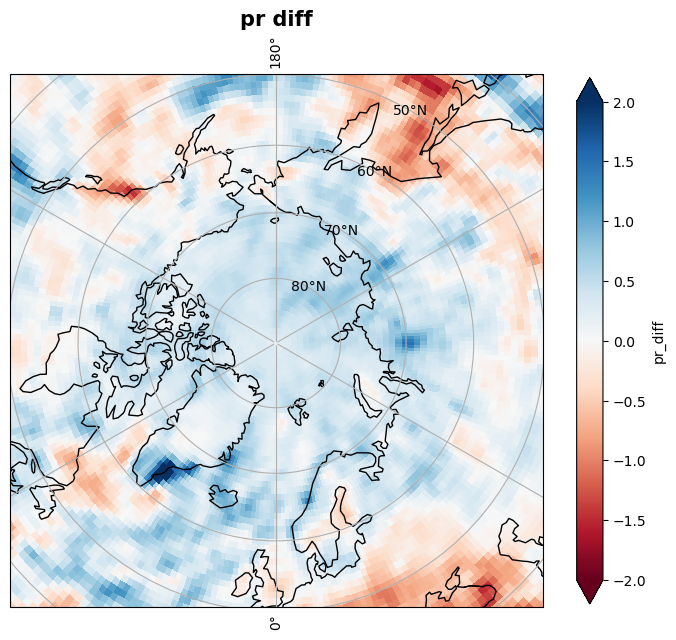

In [38]:
plot_map(ds_pr_diff['pr_diff'], 'pr diff', vmin=-2, vmax=2)

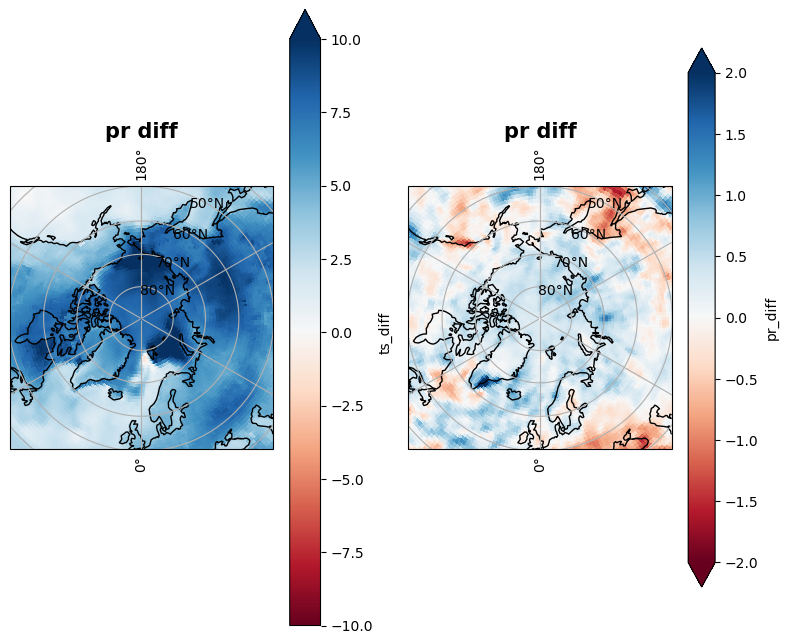

In [76]:
plot_map2(ds_temp_diff['ts_diff'], ds_pr_diff['pr_diff'], 'pr diff', vmin=-2, vmax=2)

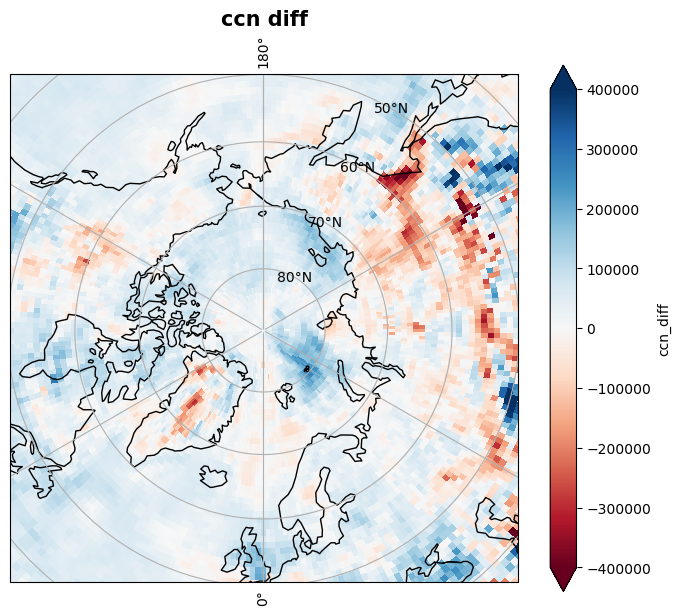

In [40]:
plot_map(ds_ccn_diff['ccn_diff'], 'ccn diff', vmin=-400000, vmax=400000)

### Seasons

In [41]:
ds_4xco2 = fix_units(ds_all); ds_piControl = fix_units(ds_all_piControl)

In [42]:
ds_season_4xco2 = ds_4xco2.groupby('time.season').mean(keep_attrs=True)
ds_season_piControl = ds_piControl.groupby('time.season').mean(keep_attrs=True)
ds_season_4xco2.sel(season='JJA')

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288, lev: 32)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 -180.0 -178.8 -177.5 -176.2 ... 176.2 177.5 178.8
  * lev      (lev) float64 0.9926 0.9763 0.9575 ... 0.01436 0.007595 0.003643
    season   <U3 'JJA'
Data variables: (12/16)
    pr       (lat, lon) float64 dask.array<chunksize=(192, 288), meta=np.ndarray>
    ccn      (lat, lon) float32 dask.array<chunksize=(192, 288), meta=np.ndarray>
    cdnc     (lev, lat, lon) float32 dask.array<chunksize=(32, 96, 96), meta=np.ndarray>
    co2      (lev, lat, lon) float32 dask.array<chunksize=(32, 96, 96), meta=np.ndarray>
    emibc    (lat, lon) float32 dask.array<chunksize=(192, 288), meta=np.ndarray>
    emibvoc  (lat, lon) float32 dask.array<chunksize=(192, 288), meta=np.ndarray>
    ...       ...
    emiso4   (lat, lon) float32 dask.array<chunksize=(192, 288), meta=np.ndarray>
    emiss    (lat, lon) float32 dask.array<chunksize=(192, 288), meta=np.ndarray>
    emivoc   (lat, lon) float32 dask.array<chunksize=(192, 288), meta=np.ndarray>
    prc      (lat, lon) float32 dask.array<chunksize=(192, 288), meta=np.ndarray>
    so2      (lev, lat, lon) float32 dask.array<chunksize=(32, 96, 96), meta=np.ndarray>
    ts       (lat, lon) float32 dask.array<chunksize=(192, 288), meta=np.ndarray>

In [43]:
season_diff = ds_season_4xco2-ds_season_piControl



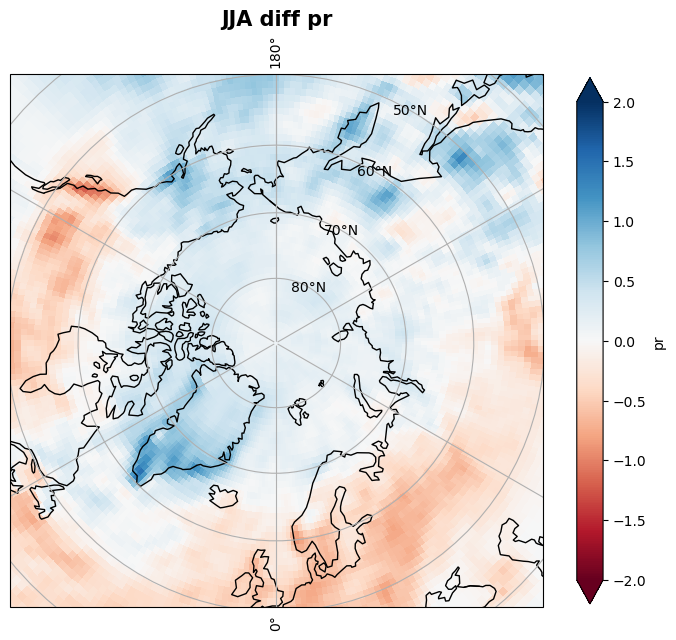

In [44]:


plot_map(season_diff['pr'].sel(season='JJA'), 'JJA diff pr', vmin=-2, vmax=2)

In [45]:
def plot_map2(nrow, ncols, ds_var, title, reverse=False, levels=6, extent=[-180,180,90,50], vmin=-0.12, vmax=0.12):
    '''
        Plots the trend on a map from the model data
        
    Args:
    -----
        var    [DataArray]   :   An xarray contining data about the conditions 
        levels [int]         :   Levels in the plot
        extent [list]        :   A list of the extent of the plot
    '''
    if reverse:
            cmap="RdBu_r"
    else:
            cmap='RdBu'
    
    sat_proj = ccrs.NorthPolarStereo()
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols,figsize=(8,8),subplot_kw={'projection':sat_proj})
    ax=ax.flatten()
    #ds_var.plot(facecolor="gray",
    #    ax = ax[1],
    #    cbar_kwargs={
     #       'orientation':'vertical',
     #       'shrink':.9
     #       },                 
        #transform=ccrs.PlateCarree(),
     #   #levels=levels,
       # vmin=vmin,
      #  vmax=vmax,
       # cmap=cmap
        #robust=True
        #)


    #dot_signif(ds, ax)
    


In [46]:
seasons = season_diff.season.values
seasons


array(['DJF', 'JJA', 'MAM', 'SON'], dtype=object)

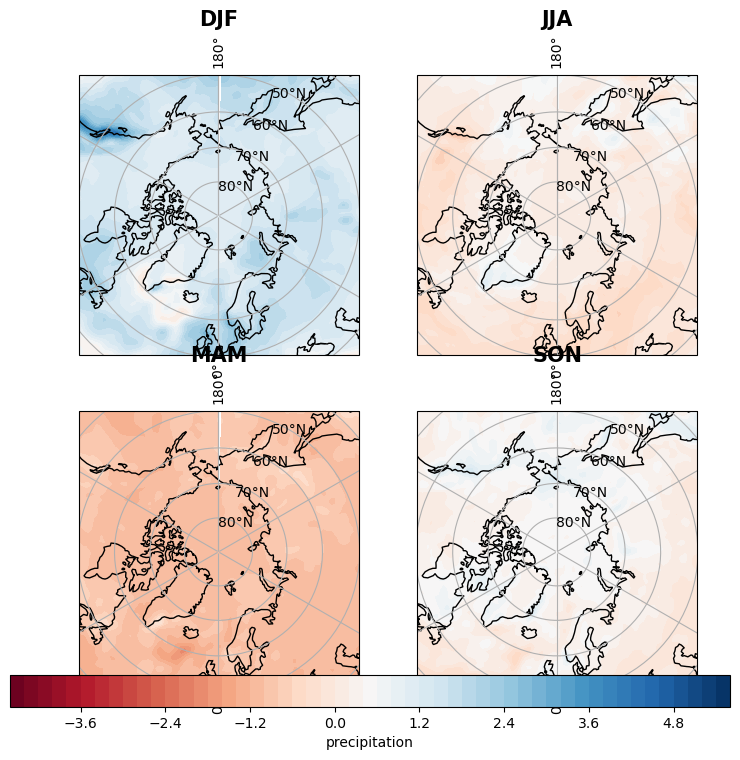

In [65]:
#  sat_proj = ccrs.NorthPolarStereo()
 #   fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(8,8),subplot_kw={'projection':sat_proj})

sat_proj = ccrs.NorthPolarStereo()
fig, axs = plt.subplots(nrows=2, ncols=2,figsize=(8,8),subplot_kw={'projection':sat_proj})    

axs=axs.flatten()

levels = 50
#levels = np.arange(-3,3,6)

for i,season in enumerate(seasons):
        # Contour plot
        cs=axs[i].contourf(season_diff.lon, season_diff.lat, season_diff['pr'].sel(season=season),
                          transform = ccrs.PlateCarree(),
                          cmap='RdBu', levels=levels)#, vmin=-3, vmax=3)#,extend='both')

        # Title each subplot with the name of the model
        axs[i].set_title(season, fontweight='bold', fontsize=15)

        # Draw the coastines for each subplot
        axs[i].coastlines()


        #cbar.set_clim(min, max)
        axs[i].set_extent([-180,180,90,50], ccrs.PlateCarree())
        axs[i].gridlines(draw_labels=True)
        
cax = fig.add_axes([.04, .09, .9, .04])
plt.colorbar(cs, cax=cax, orientation='horizontal', label='precipitation') 
#plt.adjust_plot()

#fig.tight_layout()


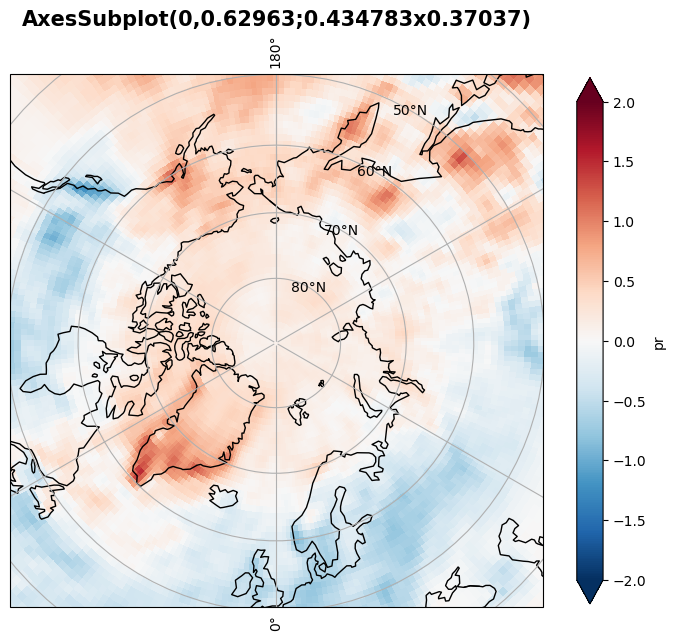

In [48]:
gs = gridspec.GridSpec(ncols=2, nrows=2, hspace = 0.7, wspace = 0.3, top = 1,
                       bottom = 0, left = 0, right = 1)

# create an ax with gs
ax = fig.add_subplot(gs[0, 0])
plot_map(season_diff['pr'].sel(season='JJA'), ax, 'JJA', 'JJA diff pr', vmin=-2, vmax=2)

/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregations.py:258: RuntimeWarning: invalid value encountered in divide
  finalize=lambda sum_, count: sum_ / count,


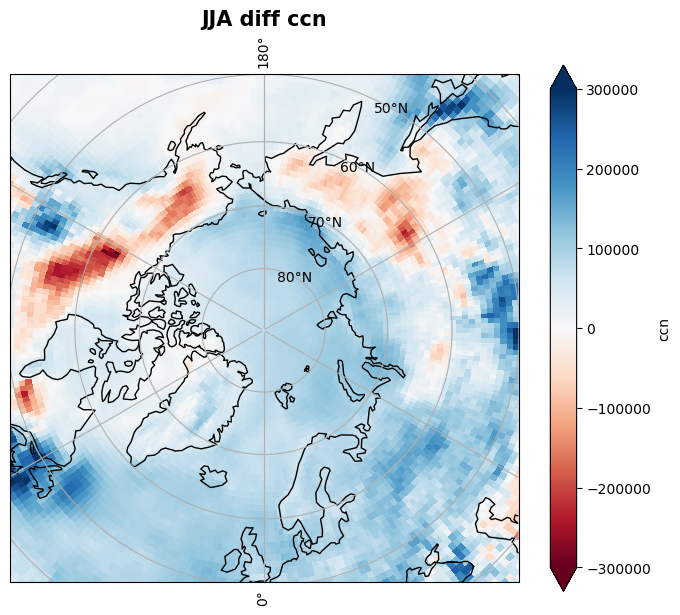

In [49]:
plot_map(season_diff['ccn'].sel(season='JJA'), 'JJA diff ccn', vmin=-300000, vmax=300000)

In [50]:
plot_map(ts_diff_trend['mk_trend'], ts_diff_trend, 'temp diff trend', reverse=True, vmin=-12, vmax=12)

NameError: name 'ts_diff_trend' is not defined